In [1]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.auto as tqdm
import itertools

In [4]:
import bbi

In [5]:
from modular_splicing.dataset.additional_data import DatafileReferencingAdditionalData
from modular_splicing.dataset.generic_dataset import dataset_types

from modular_splicing.utils.construct import construct

from modular_splicing.data_for_experiments.standardized_sample import standardized_sample
from modular_splicing.evolutionary_conservation.phylo_p import phylo_p
from modular_splicing.utils.intron_exon_annotation import ANNOTATION_EXON, ANNOTATION_INTRON

from modular_splicing.utils.run_batched import run_batched

In [6]:
xs, ys, ps = standardized_sample(
    "./dataset_test_0.h5",
    20_000,
    cl=400,
    get_motifs=True,
    datapoint_extractor_spec=dict(
        type="BasicDatapointExtractor",
        rewriters=[
            dict(
                type="AdditionalChannelDataRewriter",
                out_channel=["inputs", "motifs"],
                data_provider_spec=dict(
                    type="phylo_p",
                    datafiles={
                        "./dataset_train_all.h5": "./datafile_train_all.h5",
                        "./dataset_test_0.h5": "./datafile_test_0.h5",
                    },
                    sl=5000,
                    cl_max=10_000,
                ),
            )
        ],
    ),
)
ps = np.array(ps)
assert ps.shape[1] == 1
assert ps.shape[3] == 1
ps = ps[:,0,:,0] >= 2

In [7]:
_, annot = standardized_sample(
    "./dataset_intron_exon_annotations_test_0.h5",
    20_000,
    cl=400,
    datapoint_extractor_spec=dict(type="BasicDatapointExtractor", run_argmax=False),
)

In [8]:
cl = 400

In [9]:
from modular_splicing.models_for_testing.list import FM, AM

In [10]:
from modular_splicing.base_perturbations.swing_by_distance import distance_to_feature_center

In [11]:
from modular_splicing.evaluation.predict_motifs import predict_motifs_binarized_sparse

In [12]:
ps_relevant = ps[:,cl//2:ps.shape[1] - cl//2]

In [15]:
def distances(mod):
    mot = predict_motifs_binarized_sparse(mod.model, xs).original
    print("done with sparse")
    dist = distance_to_feature_center((mot != 0).any(-1), 20)
    return dist[:,cl//2:dist.shape[1] - cl//2]

In [16]:
dist_fm = distances(FM.non_binarized_model(1))

done with sparse


In [17]:
dist_am = distances(AM.non_binarized_model(1))

done with sparse


In [18]:
def mean_ps(dist, mask):
    return [100 * ps_relevant[(dist // chunk_size == k // chunk_size) & mask].mean() for k in tqdm.tqdm(ks)]

In [19]:
chunk_size = 5
ks = np.arange(0, 20, chunk_size)

In [20]:
spm = FM.non_binarized_model(1).model.splicepoint_model
splice_sites = run_batched(
    spm.forward_just_splicepoints, xs, 1000, pbar=tqdm.tqdm
)
dist_splice = distance_to_feature_center((splice_sites >= -10).any(-1))[
    :, cl // 2 : -(cl // 2)
]


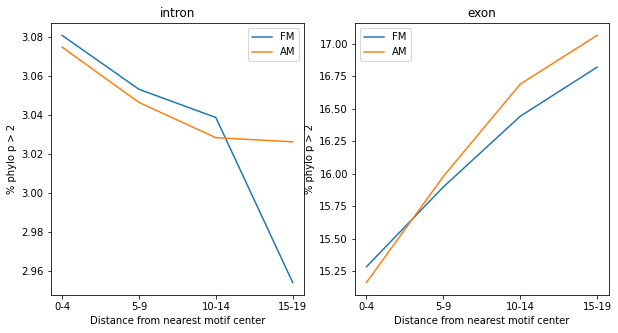

In [21]:
named_splits = [("intron", ANNOTATION_INTRON), ("exon", ANNOTATION_EXON)]

_, axs = plt.subplots(1, len(named_splits), figsize=(5 * len(named_splits),5))

for ax, (split_name, split) in zip(axs, named_splits):
    mask = (annot[:,:,0] == split) & (dist_splice > 20)
    ax.plot(ks, mean_ps(dist_fm, mask), label="FM")
    ax.plot(ks, mean_ps(dist_am, mask), label="AM")
    ax.set_xticks(ks, [f"{x}-{x + chunk_size - 1}" for x in ks])
    ax.set_xlabel("Distance from nearest motif center")
    ax.set_ylabel("% phylo p > 2")
    ax.set_title(split_name)
    ax.legend()
plt.show()

In [22]:
rstart, rend = 36690017 - 10, 36690017 + 10
with phylo_p() as f:
    loaded = f.fetch("chr1", rstart, rend)

In [23]:
from_ucsc = """
chr1	36690006	36690007	0.103
chr1	36690007	36690008	-1.066
chr1	36690008	36690009	0.176
chr1	36690009	36690010	1.052
chr1	36690010	36690011	1.052
chr1	36690011	36690012	1.417
chr1	36690012	36690013	3.900
chr1	36690013	36690014	3.681
chr1	36690014	36690015	3.900
chr1	36690015	36690016	1.709
chr1	36690016	36690017	0.322
chr1	36690017	36690018	3.900
chr1	36690018	36690019	1.563
chr1	36690019	36690020	2.439
chr1	36690020	36690021	3.681
chr1	36690021	36690022	1.782
chr1	36690022	36690023	3.900
chr1	36690023	36690024	3.097
chr1	36690024	36690025	-0.335
chr1	36690025	36690026	3.900
chr1	36690026	36690027	0.906
"""
from_ucsc = [x.split("\t") for x in from_ucsc.split("\n") if x.strip()]
_, start, end, val = zip(*from_ucsc)
start = [int(x) for x in start]
end = [int(x) for x in end]
val = [float(x) for x in val]

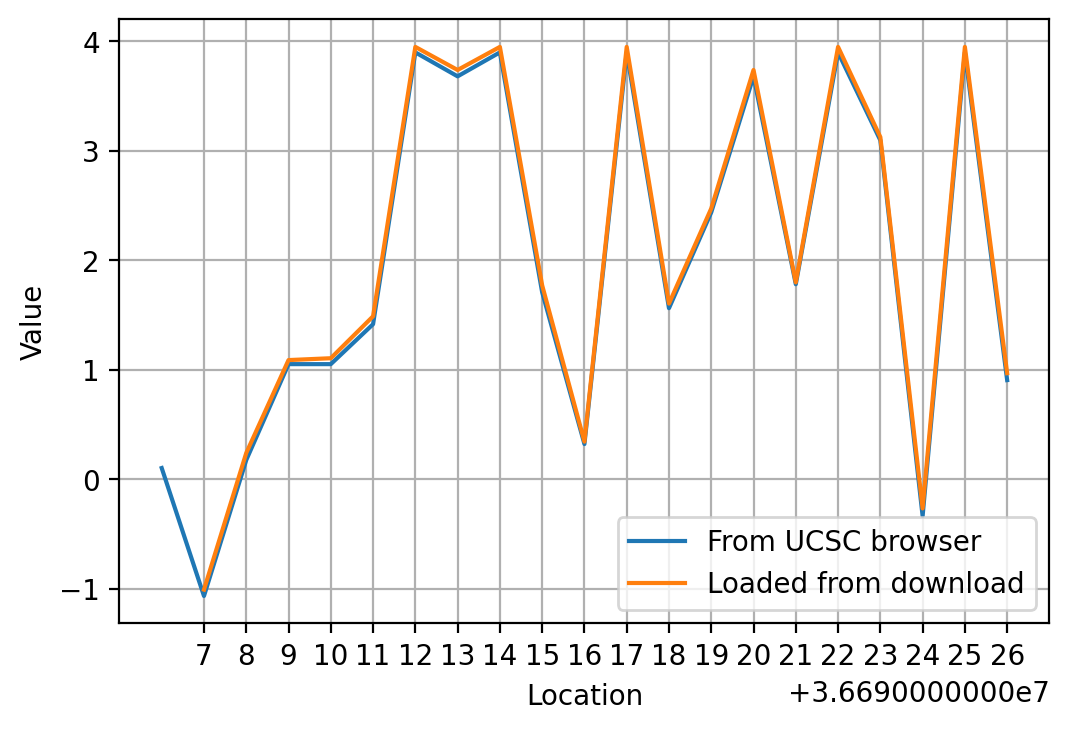

In [24]:
plt.figure(dpi=200)
plt.plot(start, val, label="From UCSC browser")
plt.plot(np.arange(rstart, rend), loaded, label="Loaded from download")
plt.xticks(np.arange(rstart, rend))
plt.grid()
plt.xlabel("Location")
plt.ylabel("Value")
plt.legend()
plt.show()